In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 

In [2]:


import torch
from diffusers import StableDiffusionXLPipeline, AutoPipelineForImage2Image
from diffusers.utils import load_image 
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display
import os 


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch_dtype = torch.float16
    print("Using GPU.")
else:
    device = torch.device("cpu")
    torch_dtype = torch.float32 
    print("Using CPU. This might be slow.")


def display_image(image: Image.Image, title="Generated Image"):
    print(f"\n--- {title} ---")
    display(image)

/home/respailab/anaconda3/envs/sohamrx/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU.


In [3]:

pipe_text_to_emoji = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch_dtype,
    variant="fp16" if torch_dtype == torch.float16 else None 
)
pipe_text_to_emoji.to(device)

print("Text-to-Emoji Pipeline (SDXL Base) loaded.")

# Optional: Enable memory savings if running into VRAM issues on GPU
# pipe_text_to_emoji.enable_model_cpu_offload() # Offloads components to CPU RAM when not in use
# pipe_text_to_emoji.enable_xformers_memory_efficient_attention() # If xformers is installed

Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 17.10it/s]


Text-to-Emoji Pipeline (SDXL Base) loaded.


Generating emoji with prompt: 'Cow driving an autorickshaw, Apple Emoji Style, plain matte unicolor white background'


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.49it/s]



--- Generic Text-to-Emoji Result ---


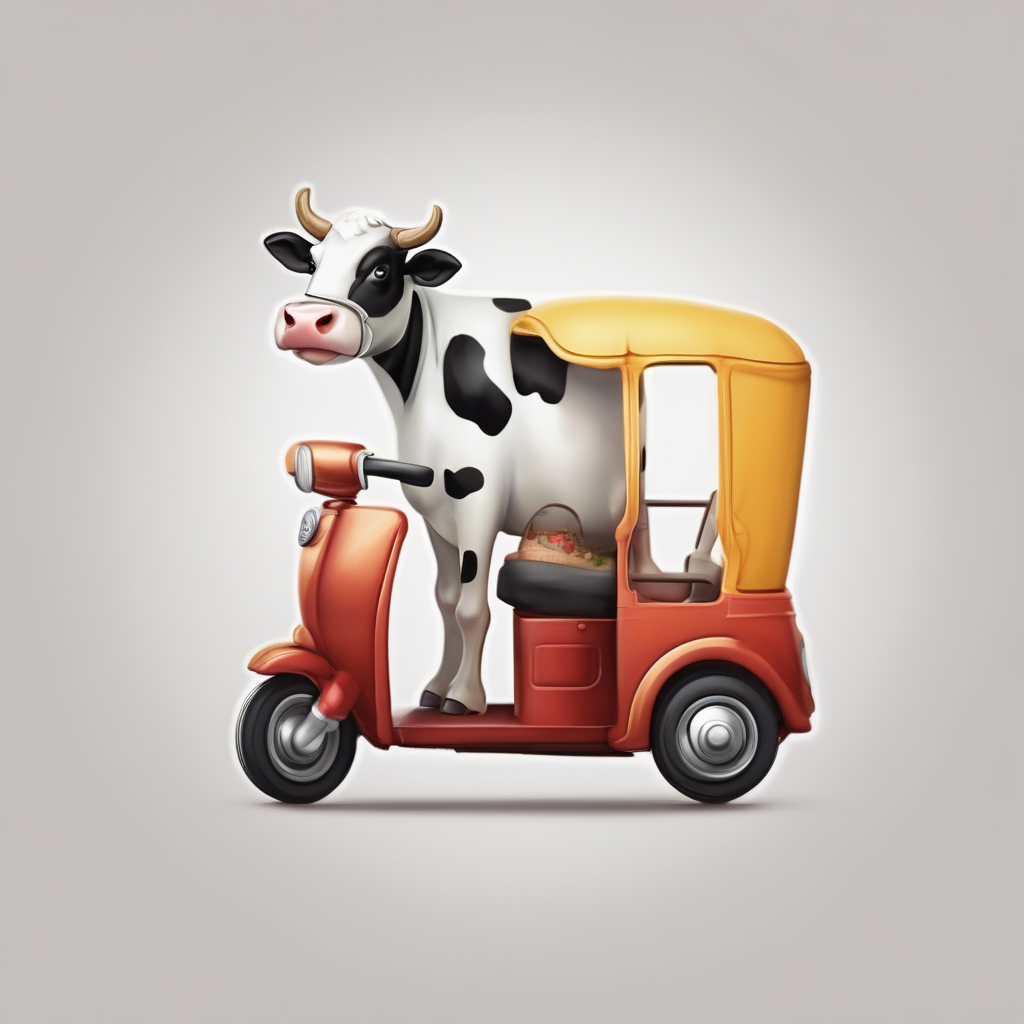

In [8]:
# @title 3. Generate Generic Emoji/Sticker (Baseline #3)

# --- User Input ---
prompt = "Cow driving an autorickshaw, Apple Emoji Style, plain matte unicolor white background"
negative_prompt = "background"
num_inference_steps = 50 
guidance_scale = 4.0

generator = torch.Generator(device=device).manual_seed(42)


print(f"Generating emoji with prompt: '{prompt}'")


with torch.no_grad(): 
    image_output = pipe_text_to_emoji(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=generator
    ).images[0]


display_image(image_output, title="Generic Text-to-Emoji Result")


# image_output.save("generic_emoji_output.png")

Using GPU.
Loading Image Encoder...
Image Encoder loaded.
Loading Text2Image Pipeline...


Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.07it/s]


Setting Scheduler...
Loading IP-Adapter weights: ['ip-adapter-plus_sdxl_vit-h.safetensors', 'ip-adapter-plus-face_sdxl_vit-h.safetensors']...
IP-Adapters loaded.
Loading face image from: https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/women_input.png
Loading style images from: https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/style_ziggy
  Loading style image 0: https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/style_ziggy/img0.png
  Loading style image 1: https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/style_ziggy/img1.png
  Loading style image 2: https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/style_ziggy/img2.png
  Loading style image 3: https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/style_ziggy/img3.png
  Loading style image 4: https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/style_ziggy/img4.png
  Loading style image 5: https://huggingface.co/datasets/Yi

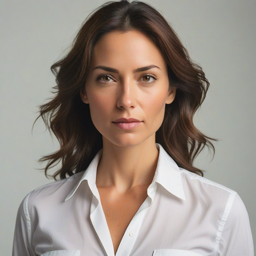

Input Face Image


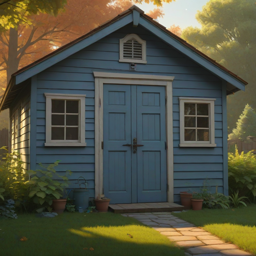

First of 10 Input Style Images
Setting IP-Adapter scales: Plus/Style=0.4, Face=0.4
Generating stylized emoji...
Prompt: '3D Style Emoji of a superhero woman, plain matte empty white background'


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.87it/s]



--- Generated Personalized Stylized Emoji ---


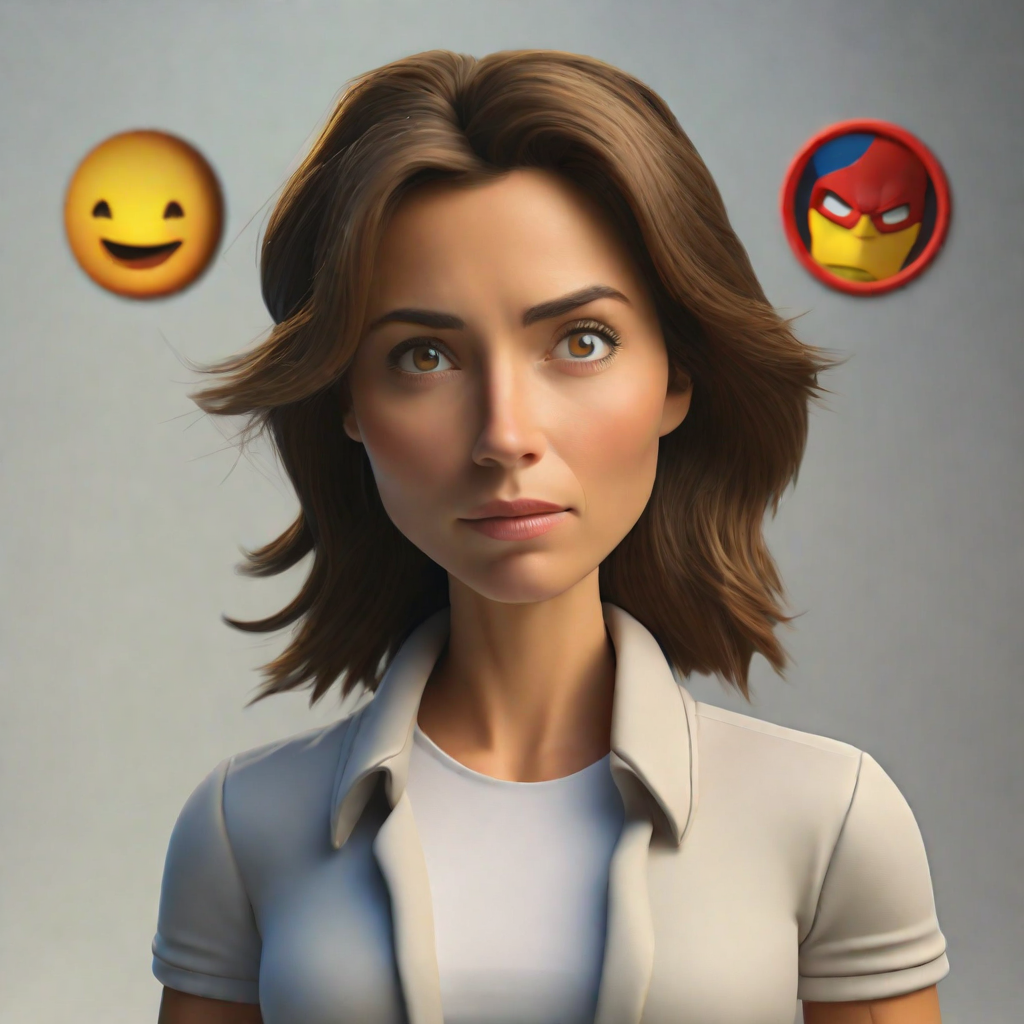

In [11]:
# @title 1. Install and Import Libraries
# !pip install diffusers transformers accelerate safetensors Pillow requests ipython -q

import torch
from diffusers import AutoPipelineForText2Image, DDIMScheduler
from transformers import CLIPVisionModelWithProjection
from diffusers.utils import load_image
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display
import os

# @title 2. Setup Device
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch_dtype = torch.float16
    print("Using GPU.")
else:
    device = torch.device("cpu")
    torch_dtype = torch.float32 # Use float32 for CPU compatibility
    print("Using CPU (will be slow).")

# @title 3. Load Image Encoder
# As per docs for IP-Adapter Plus, load image encoder manually
print("Loading Image Encoder...")
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",
    subfolder="models/image_encoder",
    torch_dtype=torch_dtype,
).to(device)
print("Image Encoder loaded.")

# @title 4. Load Pipeline and Multiple IP-Adapters
print("Loading Text2Image Pipeline...")
pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    image_encoder=image_encoder, # Pass the loaded image encoder
    torch_dtype=torch_dtype,
    variant="fp16" if torch_dtype == torch.float16 else None, # Use fp16 variant on GPU
).to(device)

print("Setting Scheduler...")
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

# Load both IP-Adapter Plus and IP-Adapter Plus Face weights
adapter_weights = ["ip-adapter-plus_sdxl_vit-h.safetensors", "ip-adapter-plus-face_sdxl_vit-h.safetensors"]
print(f"Loading IP-Adapter weights: {adapter_weights}...")
pipeline.load_ip_adapter(
  "h94/IP-Adapter",
  subfolder="sdxl_models",
  weight_name=adapter_weights
)
print("IP-Adapters loaded.")

# @title 5. Prepare Input Face and Style Images

# --- URLs from the documentation example ---
face_image_url = "https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/women_input.png"
style_folder_url = "https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/style_ziggy"

# --- Function to load image from URL ---
def download_and_load_image(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
        return img
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        return None

# --- Load the face image ---
print(f"Loading face image from: {face_image_url}")
face_image = download_and_load_image(face_image_url)

# --- Load the style images (example loads 10) ---
style_images = []
print(f"Loading style images from: {style_folder_url}")
# Limiting to 4 style images for quicker testing, adjust as needed
num_style_images_to_load = 10
for i in range(num_style_images_to_load):
    style_image_url = f"{style_folder_url}/img{i}.png"
    print(f"  Loading style image {i}: {style_image_url}")
    img = download_and_load_image(style_image_url)
    if img:
        style_images.append(img)

if face_image:
    display(face_image.resize((256, 256)))
    print("Input Face Image")
if style_images:
    display(style_images[0].resize((256,256))) # Display first style image
    print(f"First of {len(style_images)} Input Style Images")

# @title 6. Generate Personalized & Stylized Emoji (using Multi IP-Adapter)

if face_image and style_images:
    # --- Parameters ---

    adapter_scales = [0.4, 0.4] # Example: Equal weight initially. Tune these.

    prompt = "3D Style Emoji of a superhero woman, plain matte empty white background" # Changed from "wonderwoman" to be more emoji-like
    negative_prompt = ""
    num_inference_steps = 50 # Reduced steps for faster testing
    generator_seed = 42
    generator = torch.Generator(device=device).manual_seed(generator_seed)
    # --- End Parameters ---

    print(f"Setting IP-Adapter scales: Plus/Style={adapter_scales[0]}, Face={adapter_scales[1]}")
    pipeline.set_ip_adapter_scale(adapter_scales)

    print("Generating stylized emoji...")
    print(f"Prompt: '{prompt}'")

    # Pass images as a list: [style_images_list, face_image_single]
    # This order should correspond to the order of weights loaded and scales set.
    with torch.no_grad():
        output_image = pipeline(
            prompt=prompt,
            negative_prompt=negative_prompt,
            ip_adapter_image=[style_images, face_image], # List of styles, then single face image
            num_inference_steps=num_inference_steps,
            generator=generator,
        ).images[0]

    print("\n--- Generated Personalized Stylized Emoji ---")
    display(output_image)

    # Optional: Save image
    # output_image.save("multi_ipadapter_emoji.png")

else:
    print("Could not load face and/or style images. Skipping generation.")


--- Removing Background using rembg ---
Background removal complete.


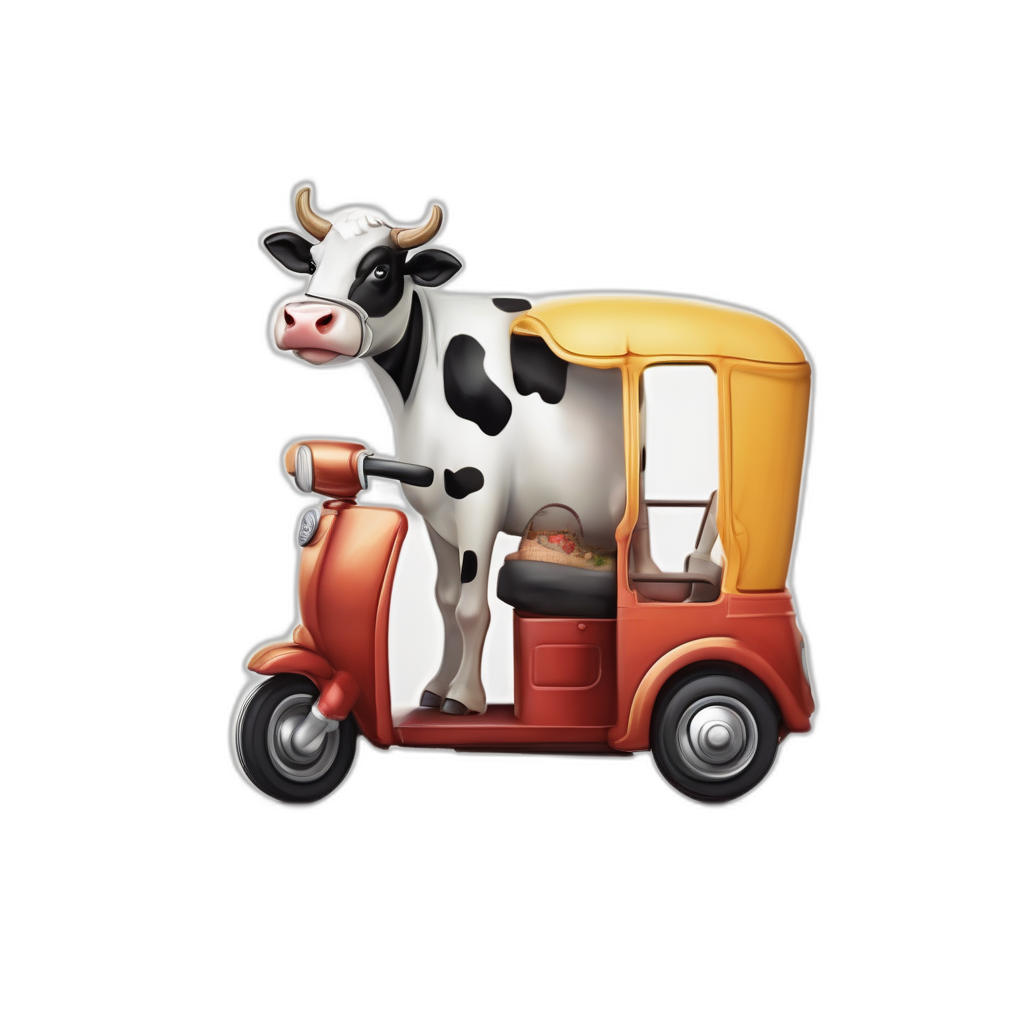

In [9]:
from rembg import remove
from PIL import Image
from IPython.display import display

# Assuming 'output_image' is the PIL Image variable from the generation step

print("\n--- Removing Background using rembg ---")

# Remove the background
try:
    image_no_bg = remove(image_output)

    print("Background removal complete.")
    # Display the result (Jupyter/Colab often show transparency correctly)
    display(image_no_bg)

    # You can save this image as PNG to preserve transparency
    # image_no_bg.save("sticker_output.png")

except Exception as e:
    print(f"Error during background removal: {e}")
    print("Ensure 'rembg' is installed and dependencies (like onnxruntime) are met.")
    # Display original if removal failed
    display(output_image)

--- Setting up for Text + Style Generation ---
Loading Text2Image Pipeline (for Text+Style)...


Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.77it/s]


Setting Scheduler...
Loading IP-Adapter Style weights: ip-adapter-plus_sdxl_vit-h.safetensors...
Style IP-Adapter loaded.
Using 10 style images.


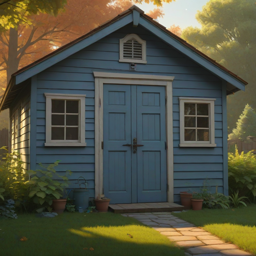

First Input Style Image (Preview)
Setting IP-Adapter style scale: 0.4
Generating emoji with text prompt and style images...
Prompt: 'cropped face of a cute winking cat in apple emoji style, plain white matte background'


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.94it/s]



--- Generated Text-to-Emoji with Style ---


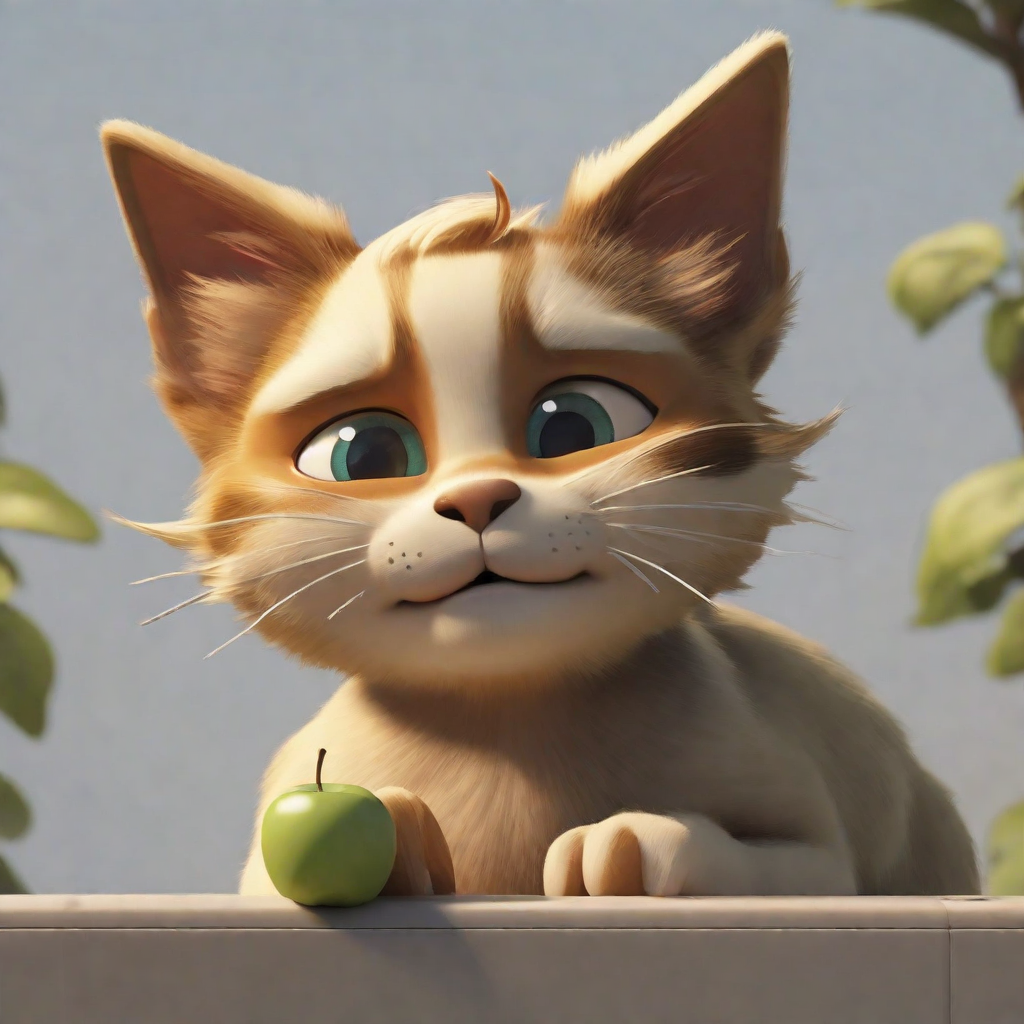


--- Removing Background (Optional) ---
Background removal complete.


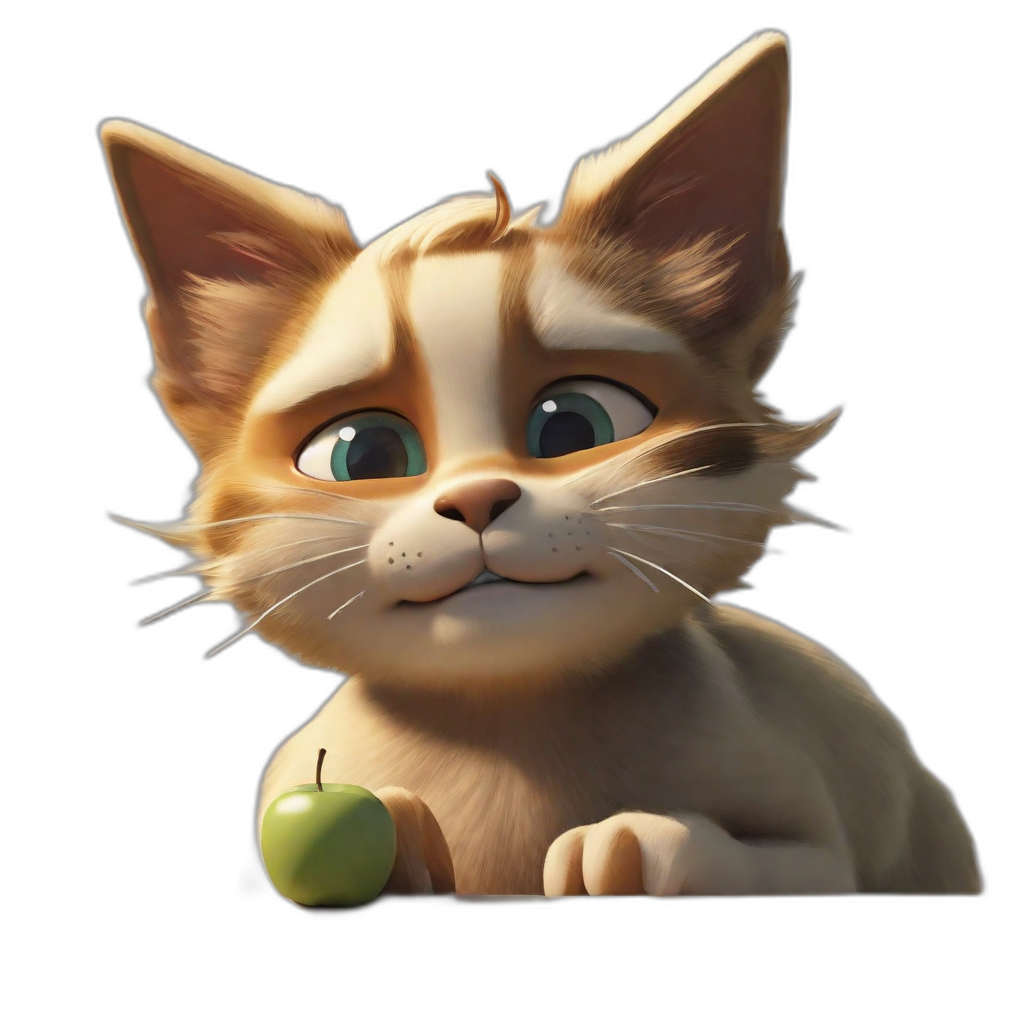

In [17]:
# @title 7. Corrected: Text-to-Emoji with Style

# --- Setup Code (Assumes previous cells run: imports, device, image_encoder, download_and_load_image) ---

print("--- Setting up for Text + Style Generation ---")
if 'image_encoder' not in globals():
     print("Error: Image Encoder not loaded. Run step 3 first.")
     # Handle error or stop

print("Loading Text2Image Pipeline (for Text+Style)...")
style_pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    image_encoder=image_encoder,
    torch_dtype=torch_dtype,
    variant="fp16" if torch_dtype == torch.float16 else None,
).to(device)

print("Setting Scheduler...")
style_pipeline.scheduler = DDIMScheduler.from_config(style_pipeline.scheduler.config)

style_adapter_weight = "ip-adapter-plus_sdxl_vit-h.safetensors"
print(f"Loading IP-Adapter Style weights: {style_adapter_weight}...")
style_pipeline.load_ip_adapter(
  "h94/IP-Adapter",
  subfolder="sdxl_models",
  weight_name=style_adapter_weight # Load only the 'plus' adapter
)
print("Style IP-Adapter loaded.")

# --- Prepare Input Style Images ---
if 'style_images' not in globals() or not style_images:
    print("Style images not found, loading defaults...")
    style_folder_url = "https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/style_ziggy"
    style_images = []
    num_style_images_to_load = 4 # Using 4 for example
    for i in range(num_style_images_to_load):
        style_image_url = f"{style_folder_url}/img{i}.png"
        img = download_and_load_image(style_image_url)
        if img:
            style_images.append(img)

if style_images:
    print(f"Using {len(style_images)} style images.")
    display(style_images[0].resize((256,256)))
    print("First Input Style Image (Preview)")
else:
    print("Error: No style images loaded. Cannot proceed.")
    # Handle error or stop

# --- Generate Text-to-Emoji with Style ---
if style_images:
    # --- Parameters ---
    prompt = "cropped face of a cute winking cat in apple emoji style, plain white matte background"
    negative_prompt = ""
    style_scale = 0.4
    num_inference_steps = 50
    guidance_scale = 4.0
    generator_seed = 50
    generator = torch.Generator(device=device).manual_seed(generator_seed)
    # --- End Parameters ---

    print(f"Setting IP-Adapter style scale: {style_scale}")
    style_pipeline.set_ip_adapter_scale(style_scale) # Single scale for the single adapter

    print("Generating emoji with text prompt and style images...")
    print(f"Prompt: '{prompt}'")

    # **CORRECTION HERE:** Pass a list containing the list of style images
    with torch.no_grad():
        style_output_image = style_pipeline(
            prompt=prompt,
            negative_prompt=negative_prompt,
            ip_adapter_image=[style_images], # Pass list_of_style_images as the single element
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator,
        ).images[0]

    print("\n--- Generated Text-to-Emoji with Style ---")
    display(style_output_image)

    # --- Optional: Background Removal ---
    print("\n--- Removing Background (Optional) ---")
    try:
        from rembg import remove
        style_image_no_bg = remove(style_output_image)
        print("Background removal complete.")
        display(style_image_no_bg)
        # style_image_no_bg.save("styled_emoji_sticker.png")
    except Exception as e:
        print(f"Could not remove background: {e}")
else:
    print("Skipping generation as style images are missing.")

# --- Cleanup (Optional) ---
# import gc
# del style_pipeline
# torch.cuda.empty_cache()
# gc.collect()